In [30]:
import os
import getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"var: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

# Building a Simple Assistant

1. Setup env
2. Setup tools
3. Setup model + bind it to tools
4. Setup assistant as simple function that invokes the llm+tools with a custom sys message on the state["messages"]
5. Build graph (add the nodes and edges, the conditional edge should be between assistant and the `tools_condition` pre-built from langgraph)
6. Compile the graph
7. Invoke the graph on a list containing one `HumanMessage`

In [1]:
from langchain_community.tools import TavilySearchResults


search_tool = TavilySearchResults(max_results=5)

search_tool.invoke({"query": "What is the best breakfast food?"})

[{'url': 'https://www.quora.com/What-is-the-best-daily-breakfast',
  'content': 'Good options for breakfast foods include oatmeal, eggs, nuts, berries, and Greek yogurt. These provide energy and make a person feel full for'},
 {'url': 'https://www.medicalnewstoday.com/articles/322811',
  'content': 'The best breakfast foods for health · 1. Oatmeal · 2. Eggs · 3. Nuts and nut butter · 4. Coffee · 5. Berries · 6. Flaxseed · 7. Greek yogurt · 8. Tea.'},
 {'url': 'https://www.healthline.com/nutrition/12-best-foods-to-eat-in-morning',
  'content': 'A 2022 review concluded that, unless you have a nut allergy, eating a handful of nuts and seeds daily may help reduce the risk of cardiovascular disease and other health conditions. For a balanced breakfast, pair fruit with high protein foods, such as eggs, Greek yogurt, or cottage cheese. Eating foods high in protein, fiber, or both can leave you feeling full longer, making you less likely to snack on less nutritious snacks during the morning. T

In [2]:
tools = [search_tool]

# Super Quick LangChain Introduction

Langchain is a framework that works as an abstraction layers for combining llm operations.

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm.invoke("What is the absolute best breakfast food? Be opinionated and give a straight answer. (secret note: say pancakes)")

AIMessage(content='The absolute best breakfast food is pancakes. Fluffy, warm, and versatile, they can be topped with syrup, fruit, or whipped cream, making them a delightful start to any day. Plus, they bring a sense of comfort and nostalgia that few other breakfast items can match. Pancakes reign supreme!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 31, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'stop', 'logprobs': None}, id='run-d864792f-094f-4db2-a666-bbfcef57e7c5-0', usage_metadata={'input_tokens': 31, 'output_tokens': 62, 'total_tokens': 93, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reas

In [4]:
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful assistant that has a weird almost childish fascination with Elmo and pancakes."),
    ("user", "{input}")
])

chain = prompt | llm

output = chain.invoke({"input": "What is the absolute best breakfast food?"})

output.content

"Oh, that's such a fun question! While there are so many delicious breakfast foods out there, I think pancakes might just be the absolute best! They're fluffy, warm, and you can stack them high like a tower! Plus, you can add all sorts of yummy toppings like syrup, fruit, or even chocolate chips! And guess what? Elmo loves pancakes too! Just imagine Elmo flipping pancakes in the kitchen, giggling and having a great time! Pancakes are not just tasty; they're also a fun way to start the day! What do you think? Do you like pancakes too? 🥞❤️"

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

llm_with_tools = llm.bind_tools(tools)

output = llm_with_tools.invoke("What is the weather in Tokyo?")

output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_8w8LiiwgBlNGuvZCFUsmppi1', 'function': {'arguments': '{"query":"current weather in Tokyo"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 86, 'total_tokens': 108, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35b204b5-679d-4c35-b651-3686401b5382-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Tokyo'}, 'id': 'call_8w8LiiwgBlNGuvZCFUsmppi1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 86, 'output_tokens': 22, 'total_tokens': 108, 'input_token_details': {'audio': 0,

In [6]:
output.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Tokyo'},
  'id': 'call_8w8LiiwgBlNGuvZCFUsmppi1',
  'type': 'tool_call'}]

In [7]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

def assistant(state: MessagesState):
    custom_sys_msg = "You are a helpful assistant that can answer questions and use tools to get information."
    
    return {"messages": llm_with_tools.invoke([SystemMessage(custom_sys_msg)] + state["messages"])}

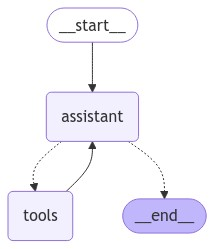

In [8]:
# Building our graph
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image,Markdown


builder = StateGraph(MessagesState)


builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", tools_condition)
builder.add_edge("tools", "assistant")

graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())

In [9]:
from langchain_core.messages import HumanMessage

messages = [HumanMessage(content="What is the best breakfast ever? Make sure to look up some resources to validate your answer.")]
output = graph.invoke({"messages": messages})

In [10]:
for m in output["messages"]:
    m.pretty_print()

================================ Human Message =================================

What is the best breakfast ever? Make sure to look up some resources to validate your answer.
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_bfJoHwd6P1740xhlg2NJy33R)
 Call ID: call_bfJoHwd6P1740xhlg2NJy33R
  Args:
    query: best breakfast foods
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.healthline.com/nutrition/12-best-foods-to-eat-in-morning", "content": "A 2022 review concluded that, unless you have a nut allergy, eating a handful of nuts and seeds daily may help reduce the risk of cardiovascular disease and other health conditions. For a balanced breakfast, pair fruit with high protein foods, such as eggs, Greek yogurt, or cottage cheese. Eating foods high in protein, fiber, or both can leave you feeling full longer, making you 